# Classification /extraction 
--- 

we should consider only some properties derivated  from items but in this case we can build a vocabulary of property initially for two categories **Culture Representative** and **Culture Agnostic**. 


### How should we chose properties from item of Culture Agnostic and Culture Representative? 
### Training  Phase:

--- 

### Step 1: Building 1 vocabulary of properties associated to Culture Representative and Culture Agnostic 
In this phase, for every sample $ item_{i} $ associated to, we put all its properties  into a set  $S_{P} $
### Step 2: Embedded vectors of properties for every item 
In this case we associate a binary vector for every $item_{i} $ where for every possible property we associate 1 if it has that property $P_k$ otherwise 0.
### Step 3: Compute the centroids for every category C.A C.R, C.E.X
Now, after the preprocessed data we compute the centroid (like mean over every property $P_k$ on all samples) $C_{CA} $ and $C_{CR} $.
### Step 4: We compute the euclidean distance among properties and centroids
for every sample we compute distance among each property and centroids, so we will interpret strong relationship of some  properties wrt culture concepts while for concept more neutrals
### Step 5: Corresponding the similarity to every property with some methods wrt centroids
Every property, will have a weight computed following the importance of distance wrt centroids $C_{C.A} $ and  $ C_{C.R}$ : 

### Test Phase:

### Step 1: Compute distance among every element wrt to the both centroids
we compute per every $item_i$  and every feature of kind: $P_{123},P_{2345} $ ecc... the euclidean distance
### Step 2: Compute similarity for every test sample(with kernel approach) for both centroids
this pass helps us to understand in which direction a sample should go to the centroids for both centroids 
### Step 3: Given averaged sum of the importance of feature of samples 
in this step we compute, Culture and Agnostic_score= $ \sum_{fi=1}^{N_feat} item_{fi}* importance \space of  \space features $  the secnond term is measured in previous case
### Step 4 : Then, to emphasize the influence of entities closer to the centroids, we multiply the weighted score by the similarity.
So, ultimately, we multiply the weighted score by similarity to get a total score that is more sensitive to the entity's proximity to the centroids. This helps make a more accurate prediction based on how much the entity resembles the cultural or agnostic centers.

total_culture_score=$ Culture \space and  \space Agnostic_score * similarity \space of \space distance \space of \space test_sample $ repeated for every class score
total_agnostic_score = ... 
### Step 5: Classification based on best result
if total_culture_score > total agnostic_score  -> **Culture Representative**









In [1]:
from datasets import load_dataset
import pandas as pd
import torch as t 
import numpy as np
import matplotlib.pyplot as plt
from wikidata.client import Client
from itertools import islice
from collections import Counter,defaultdict
from concurrent.futures import ThreadPoolExecutor
from scipy.spatial.distance import euclidean
from statistics import mean, stdev
import urllib.error
import json
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay,accuracy_score

### Load Dataset

In [2]:
ds=load_dataset("sapienzanlp/nlp2025_hw1_cultural_dataset") #load dataset from Hugging face

train_set=train_data=pd.DataFrame(ds["train"]) #take train_set and it is treated as dataframe
test_set=train_data=pd.DataFrame(ds["validation"]) #take validation set and it is treated as validation_set

list_category=set(list(train_set.category))  #list category of samples (19)
list_subcategory=set(list(train_set.subcategory)) #list sub_category of samples (118)

X_train=train_set.values #take dataset like a matrix of Numpy

print(X_train) # stamp all training dataset 

validation_set=pd.DataFrame(ds["validation"]) #take validation set and  it is treated as dataframe
X_valid=validation_set.values #take dataset like a matrix of Numpy

print(X_valid)

[['http://www.wikidata.org/entity/Q32786' '916' '2012 film by M. Mohanan'
  ... 'films' 'film' 'cultural exclusive']
 ['http://www.wikidata.org/entity/Q371' '!!!'
  'American dance-punk band from California' ... 'music' 'musical group'
  'cultural representative']
 ['http://www.wikidata.org/entity/Q3729947' '¡Soborno!'
  'Mort & Phil comic' ... 'comics and anime' 'comics'
  'cultural representative']
 ...
 ['http://www.wikidata.org/entity/Q10779' 'Zwenkau'
  'city in the district of Leipzig, in the Free State of Saxony, Germany'
  ... 'geography' 'city' 'cultural exclusive']
 ['http://www.wikidata.org/entity/Q245296' 'zydeco'
  'music genre evolved in southwest Louisiana which blends blues, rhythm and blues, and music indigenous to the Louisiana Creoles and the Native people of Louisiana'
  ... 'music' 'music genre' 'cultural representative']
 ['http://www.wikidata.org/entity/Q129298' 'Zygmunt Chmielewski'
  'actor (1894-1978)' ... 'performing arts' 'theatrical director'
  'cultural ex

# Training phase
## Step 1: Building a Vocabulary with the most important properties of training items
---
### Function manipulates url of entity item and sample for feature **category**

In [3]:
#function which extracts wiki-item Qxxx 
def extract_entity_id(url): 
    return url.strip().split("/")[-1] 

#function which extracts sample for feature: category 
def extract_sample_from_cat(X,cat):
    l=list()
    for elem in X:
        if elem[4]==cat:
            l.append(elem[0])
    return np.array(l) #transforms all sample like a matrix of numpy (sample_category,6)
client = Client() #create object Client

### Function for bulding vocabulary of properties

In [4]:

vocabulary=list()

def build_vocabulary(cat):
    vocabulary_subset=list()
    list_sample_cat=extract_sample_from_cat(X_train,cat)
    #number_list_sample_cat=len(list_sample_cat)
    #print("sample category: "+cat)
    #print(len(list_sample_cat))
    set_properties=list()
    #set_properties=np.array(set_properties)
    for url in list_sample_cat:
        entity_train=extract_entity_id(url)
        #-----Check on entity train
        if not entity_train or not entity_train.startswith("Q"): #verify if entity_id starts with Q
            continue
        try:
            item = client.get(entity_train, load=True)
        except urllib.error.HTTPError: #handle error of HTTP error like HTTP 404
            continue
        #------
        claim_item_i=item.data.get("claims",{})
       # print(claim_item_i)
        #print(len(claim_item_i))
        set_property_item=set()
        for prop_id,values in islice(claim_item_i.items(),len(claim_item_i)):
            #prop_entity = client.get(prop_id, load=True)
            #label = prop_entity.label
            #print(f"{prop_id} = {label} ({len(values)} statement{'s' if len(values) != 1 else ''})")
            set_property_item.add(str(prop_id))
        set_properties.append(set_property_item)

    print("Category:"+cat+" collected")




    property_presence_sample=defaultdict(list) #dizionario in cui ogni key è una property e value=[1,0,0,1] lunga quanto numero di sample con 1=se propid appartiene a quel sample
    all_props = set().union(*set_properties)  # insieme di tutte le proprietà presenti nei sample
    for prop in all_props:
        for prop_set in set_properties:
            # append 1 se la proprietà è presente nel sample, altrimenti 0
            property_presence_sample[prop].append(1 if prop in prop_set else 0)
    
    filtered_props = []

    for prop, values in property_presence_sample.items():
        prop_mean = mean(values)
        if len(values) > 1:
            prop_std = stdev(values)  
        else:
            prop_std=0
        #if prop_mean >= 0.5:
        filtered_props.append((prop, prop_mean, prop_std))
    #print(f"tuple props (prop,mean,std) {filtered_props}")

    counter=Counter()
    for s in set_properties:
        counter.update(s)
        #for prop in s:
         #   counter[prop]+=1
    #frequency_prop=counter
    #frequency_prop=count_frequency_prop_id(set_properties)
    #sorted_prop=frequency_prop.most_common()
   # print(sorted_prop)
    #threshold=int(len(sorted_prop)*0.6)
    # ERROR
    prop_counts = list(counter.values())
   # print(f"Counts prop {prop_counts}")
    #------
    mu=mean(prop_counts)
    if len(prop_counts)> 1:
        dev_std=stdev(prop_counts)
    else:
        dev_std=0
    #print(f"mean : {mu} and std_dev {dev_std}")
    #th=0.2
    #if(number_list_sample_cat>=429):
    #    th=0.35
    #elif number_list_sample_cat>=300:
    #    th=0.4
    #elif number_list_sample_cat>=150:
     #   th=0.45
    #th=dynamic_threshold(number_list_sample_cat)
    #for prop_i,count in sorted_prop:
      #  support_categories=count/number_list_sample_cat
      #  if support_categories>=th: #min support 
      #      vocabulary_subset.append(prop_i)
        #if len(vocabulary_subset)>=6: #the first top k
            #break
    #print("Updated Vocabulary",vocabulary_subset) 
    #-----  
    coeff_var = dev_std / mu if mu > 0 else 0.0
    z_th = 1.0 + 0.5* coeff_var
    z_th = min(max(z_th, 1.0),8.0)
    print(f"threshold category {cat}: {z_th}")
    #z_th=10.0
    #for prop_id,count in counter.items():
    for prop_id,mu_prop,dev_s_prop in filtered_props:
        #coeff_var = dev_s_prop / mu_prop if mu_prop > 0 else 0.0
        #z_th = 1.0 + 0.5* coeff_var
        #z_th = min(max(z_th, 1.0),2.0)
        z_score=(counter.get(prop_id)-mu_prop)/dev_s_prop # apply zscore
        if z_score>=z_th:
            vocabulary_subset.append(prop_id)
    print(f"Vocabulary {cat}: {vocabulary_subset}")       
    return vocabulary_subset
        #set_property_item.clear()
    #print("intersection of sample belongs"+cat,set.intersection(*set_properties))

        #label = prop_entity.labels
        #print(claim_item_i)


### Extract the most frequent properties observing sample for every feature category

In [ ]:
# We use thread approach to parallelize the extraction of properties for category 
with  ThreadPoolExecutor(max_workers=5) as executor:
    results=list(executor.map(build_vocabulary,list_category)) #every thread executes function build_vocabulary with one of category belonging to list_category  

for vocab in results:
    vocabulary.extend(vocab)
vocabulary=list(set(vocabulary))
print("Updated Vocabulary: for categories",vocabulary)
with open("vocabulary_category.json", "w") as f: #open in write mode the file "vocabulary_category.json" and put in vocabulary of properties
    json.dump(vocabulary, f)

Category:performing arts collected
threshold category performing arts: 2.0088580639487823
Vocabulary performing arts: ['P345', 'P2850', 'P8669', 'P8013', 'P8977', 'P2168', 'P1963', 'P10018', 'P8805', 'P8568', 'P7433', 'P6705', 'P1442', 'P8511', 'P11120', 'P6968', 'P4602', 'P1344', 'P9287', 'P10916', 'P1615', 'P102', 'P2639', 'P8945', 'P3888', 'P7803', 'P9536', 'P6900', 'P8415', 'P1071', 'P2510', 'P5287', 'P945', 'P7192', 'P2087', 'P860', 'P7356', 'P7039', 'P7800', 'P9374', 'P5243', 'P4235', 'P6911', 'P1938', 'P1476', 'P1220', 'P7275', 'P3602', 'P7836', 'P2298', 'P5319', 'P648', 'P6714', 'P9463', 'P7353', 'P6804', 'P1786', 'P6760', 'P5421', 'P10', 'P948', 'P4193', 'P9613', 'P8092', 'P3430', 'P53', 'P723', 'P5056', 'P6918', 'P4084', 'P5429', 'P8589', 'P9223', 'P6683', 'P5337', 'P6412', 'P10489', 'P8969', 'P2481', 'P12046', 'P3056', 'P9469', 'P7553', 'P11514', 'P6214', 'P4012', 'P1651', 'P3569', 'P11196', 'P1705', 'P7293', 'P5622', 'P7188', 'P13437', 'P5357', 'P7934', 'P8785', 'P4399', 'P

## Step 1: Embedding in binary vectors 
--- 

### Functions to compute **weights_property, weigths distance estimation and embedding sample**

In [28]:
 

from scipy.spatial.distance import euclidean
from sklearn.feature_selection import mutual_info_classif

#compute the correlation among sample(already encoded with 1/0) wrt a single Y_label 
def weight_property(X,Y):
    mi_result=mutual_info_classif(X, Y,discrete_features=True) #compute the mutual information wrt a Y_label
    
    weighted_mi_result=mi_result/np.sum(mi_result) # normalize the values to obtain a weighted result
    
    return weighted_mi_result

#compute the weigth of sample associated to distance from a centroid X2 (less distance->moreweights)
def weight_distance_estimation(X1,X2):
    dist=np.sqrt(np.sum((X1 - X2)**2)) #compute euclidean distance among X1 and X2
    
    weights=1/(dist+1e-8) #inverse of distance like a weights 
    
    return weights

#function of embedding sample with methodology one-hot-encoding if sample X has property  Pxxx belongs a vocabulary,then the result will be an i-position of vector 1 otherwise 0   
#----------
def embedding_sample(X,vocabulary):
    X_train_emb=np.zeros((X.shape[0],len(vocabulary)),dtype=np.int32) #create matrix of x_train_embedded (X_dimension,n_properties of vocabulary)
    #function called from until 6 threads to avoid bottleneck of execution: it will be named for every index of sample j so the embedding will be executed from more threads
    def process_sample(j):
        ent=extract_entity_id(X[j,0]) #take the entity id for every sample j Qxxx 
        if not ent or not ent.startswith("Q"): #verify if entity_id starts with Q
            return j,None
        try:
            item= client.get(ent, load=True) #extract item associated to wikidata Qxxx
        except urllib.error.HTTPError: #handle error of HTTP error like HTTP 404
            return j,None
        
        claim_item_i=item.data.get("claims",{}) #get all "claims" of every item like a dictionary with more properties 

        set_p=set() #set of properties is created for every wikidata item 
        for prop_id,__ in islice(claim_item_i.items(),len(claim_item_i)):
            set_p.add(str(prop_id)) #add properties in set

        sample=np.zeros(len(vocabulary),dtype=np.int32) #create single sample j 1/0 

        for v in range(0,len(vocabulary)):
            if vocabulary[v] in set_p: #if property v belong to the set_p of that sample -> sample index v will have 1 
                sample[v]=1 
        return j,sample
     
    with ThreadPoolExecutor(max_workers=6) as executor:  
        results = executor.map(process_sample, range(X.shape[0])) #every thread will execute function process_sample on all index of sample X.
    
    for i,sample_embedded in results: 
        if sample_embedded is not None:
            X_train_emb[i]=sample_embedded #update only sample one hot encoding at index i 
    return X_train_emb

### Open saved vocabulary  

In [ ]:
with open("vocabulary_category.json","r",encoding="utf-8") as f: #open file vocabulary_category.json in read mode to load the stored vocabulary contains properties
    vocabulary_j=json.load(f)
print(vocabulary_j)

['P345', 'P6151', 'P8223', 'P421', 'P8669', 'P13300', 'P5691', 'P6465', 'P1963', 'P8977', 'P5152', 'P1121', 'P3177', 'P9705', 'P8673', 'P2703', 'P6537', 'P516', 'P10908', 'P13410', 'P10326', 'P12453', 'P8195', 'P8568', 'P2029', 'P2389', 'P1564', 'P5494', 'P12884', 'P4861', 'P1442', 'P1285', 'P4354', 'P11120', 'P4655', 'P1114', 'P9287', 'P4717', 'P1059', 'P10786', 'P10116', 'P11586', 'P6589', 'P6094', 'P7387', 'P7588', 'P1482', 'P2196', 'P1714', 'P102', 'P8636', 'P8592', 'P7971', 'P6133', 'P3888', 'P1332', 'P2772', 'P5775', 'P8415', 'P1264', 'P2622', 'P1339', 'P3902', 'P2280', 'P2510', 'P7329', 'P501', 'P1979', 'P5287', 'P5080', 'P945', 'P9888', 'P10168', 'P12585', 'P2472', 'P1788', 'P4235', 'P6911', 'P6933', 'P3284', 'P417', 'P2125', 'P1220', 'P7275', 'P3602', 'P2975', 'P10114', 'P12933', 'P1230', 'P648', 'P9514', 'P6804', 'P4219', 'P1786', 'P9258', 'P6760', 'P5421', 'P2869', 'P5593', 'P4193', 'P7311', 'P5922', 'P2631', 'P2097', 'P6814', 'P275', 'P5414', 'P5056', 'P8958', 'P7438', 'P49

### Embedding **Cultural Representative Samples**

In [8]:
print("Embedding culture representative samples")
culture_representative_train=embedding_sample(X_train[X_train[:,6]=='cultural representative'],vocabulary_j)


Embedding culture representative samples
embedded sample (4, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (1, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (2, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (5, array([1, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (0, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (7, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (6, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (3, array([1, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (8, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (10, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (9, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (13, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (11, array([1, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (12, array([1, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (14, array([1, 0, 0, ..., 0, 

### Embedding **Cultural Agnostic samples**

In [13]:
print("--Embedding culture agnostic sample")
culture_agnostic_train=embedding_sample(X_train[X_train[:,6]=='cultural agnostic'],vocabulary_j)

--Embedding culture agnostic sample
embedded sample (4, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (3, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (0, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (1, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (2, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (5, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (6, array([1, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (9, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (7, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (8, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (11, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (13, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (12, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (14, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (15, array([0, 0, 0, ..., 0, 0, 0]

### Embedding **Cultural Exclusive samples**

In [14]:
print("--Embedding Culture exclusive sample")
culture_exclusive_train=embedding_sample(X_train[X_train[:,6]=='cultural exclusive'],vocabulary_j)

--Embedding Culture exclusive sample
embedded sample (5, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (4, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (1, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (3, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (0, array([1, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (7, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (6, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (2, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (8, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (10, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (9, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (13, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (11, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (14, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (12, array([0, 0, 0, ..., 0, 0, 0

### Save all result in **train_sample_embeddings.npz**

In [15]:

print(f"culture_agnostic_train: {culture_agnostic_train}")
print(f"cutlure agnostic shape {culture_agnostic_train.shape}")

print(f"culture_representative_train {culture_representative_train}")
print(f"culture_representative_train shape {culture_representative_train.shape}")

print(f"culture_exlusive_train {culture_exclusive_train}")
print(f"culture_exlusive_train shape {culture_exclusive_train.shape}")

np.savez("train_sample_embeddings.npz",representative=culture_representative_train,agnostic=culture_agnostic_train,exclusive=culture_exclusive_train)


culture_agnostic_train: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
cutlure agnostic shape (1872, 4315)
culture_representative_train [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
culture_representative_train shape (1688, 4315)
culture_exlusive_train [[1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
culture_exlusive_train shape (2691, 4315)


### Transform Label **Culture Agnostic**, **Culture Representative**, **Culture Exclusive** into **0,1,2**

In [29]:
#Function which transform the label Y ["cultural agnostic","cultural representative","cultural exclusive"] into [0,1,2]
def numerical_label(Y):
    Y_index=np.zeros(Y.shape[0],dtype=np.int32)
    for i in range(0,Y.shape[0]):
        if Y[i]=="cultural agnostic":
            Y_index[i]=0
        elif Y[i]=="cultural representative":
            Y_index[i]=1
        else:
            Y_index[i]=2
    return Y_index
#Function which transform all sample labels==label->1 otherwise 0
def binary_label(Y,label):
    return (Y==label).astype(int)

## Step:2 Compute Centroids and weight_property
---

### Compute weights of embedded sample properties wrt singular label and compute centroids   

In [ ]:
train_embedded=np.load("train_sample_embeddings.npz")


#concatenate all samples 
all_train_sample=np.concatenate((train_embedded["agnostic"],train_embedded["representative"],train_embedded["exclusive"]),axis=0)

#compute weights of properties considering all training samples wrt single label   
weights_properties_MI_agnostic=weight_property(all_train_sample,binary_label(X_train[0:,6],"cultural agnostic"))
weights_properties_MI_representative=weight_property(all_train_sample,binary_label(X_train[0:,6],"cultural representative"))
weights_properties_MI_exclusive=weight_property(all_train_sample,binary_label(X_train[0:,6],"cultural exclusive"))

print(f"weight_property MI Agnostic {weights_properties_MI_agnostic}")
print(f"weights_property MI representative {weights_properties_MI_representative}")
print(f"weights_properties MI exclusive {weights_properties_MI_exclusive}")

#compute 3 centroids:centroid agnostic,centroid representative,centroid exclusive 
centroid_agnostic=np.mean(train_embedded["agnostic"],axis=0)
print(f"centroid agnostic for each property {centroid_agnostic.shape}",centroid_agnostic)
centroid_representative=np.mean(train_embedded["representative"],axis=0)
print(f"centroid_representative {centroid_representative.shape}",centroid_representative)
centroid_exclusive=np.mean(train_embedded["exclusive"],axis=0)
print(f"centroid_exclusive {centroid_exclusive.shape}",centroid_exclusive)









weight_property MI Agnostic [1.21939348e-06 1.49849738e-04 5.07667671e-04 ... 2.87850321e-04
 4.39674877e-05 5.07667671e-04]
weights_property MI representative [2.17911308e-04 1.29237498e-04 1.29237498e-04 ... 2.04828051e-04
 3.40358115e-06 1.29237498e-04]
weights_properties MI exclusive [1.45068321e-04 3.40719854e-04 2.27585174e-04 ... 6.81648996e-04
 2.05938291e-05 2.27585174e-04]
centroid agnostic for each property (4315,) [0.01121795 0.         0.         ... 0.         0.00213675 0.00053419]
centroid_representative (4315,) [0.28080569 0.00059242 0.00059242 ... 0.00473934 0.00059242 0.        ]
centroid_exclusive (4315,) [0.0780379  0.         0.         ... 0.         0.00111483 0.        ]
embedded sample (5, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (1, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (0, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (3, array([1, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (6, array([0, 0, 0,

### Stored weights,centroids and embedded validation samples in corresponding file **weights_properties_MI.npz**,**centroids_every_label.npz**, **X_valid_embedded.npz**

In [30]:
np.savez("weights_properties_MI.npz",weights_properties_CA=weights_properties_MI_agnostic,weights_properties_CR=weights_properties_MI_representative,weights_properties_CE=weights_properties_MI_exclusive)
np.savez("centroids_every_label.npz",centroid_CA=centroid_agnostic,centroid_CR=centroid_representative,centroid_CE=centroid_exclusive)

X_valid_embed=embedding_sample(X_valid,vocabulary_j)
np.savez("X_valid_embedded.npz",validation_embedded=X_valid_embed)

## Testing phase
---

### Function of prediction entity

In [34]:
def predict_entity_score(x_sample,centroid_CA,centroid_CR,centroid_CE,weights_CA,weights_CR,weights_CE):  
    #compute distance of same sample wrt 3 centroids obtaining 1/dist for all 3 weights proportional inverse to distance
    similiraty_sample_CA=weight_distance_estimation(x_sample,centroid_CA) 
    similarity_sample_CR=weight_distance_estimation(x_sample,centroid_CR)
    similarity_sample_CE=weight_distance_estimation(x_sample,centroid_CE)
 
    Sum_score_CA=0
    Sum_score_CR=0
    Sum_score_CE=0

    #compute the sum of all weights (corresponding properties evaluated on 3 classes) multiplied for current properties of that sample.  
    for i in range(0,x_sample.shape[0]):
      Sum_score_CA+=x_sample[i]*weights_CA[i]
      Sum_score_CR+=x_sample[i]*weights_CR[i]
      Sum_score_CE+=x_sample[i]*weights_CE[i]
    
    mean_score=(Sum_score_CA+Sum_score_CR+Sum_score_CE)/3
    #compute the final score for every class using mean_score of weights* similarity wrt CA,CR,CE
    total_score_agnostic=mean_score*similiraty_sample_CA
    total_score_representative=mean_score*similarity_sample_CR
    total_score_exclusive=mean_score*similarity_sample_CE

    return np.argmax([total_score_agnostic,total_score_representative,total_score_exclusive])

### Loading **train_sample_embedded,centroids,weights_properties,valid_embedded** 

In [ ]:
train_embedded=np.load("train_sample_embeddings.npz")
centroids=np.load("centroids_every_label.npz")
weights=np.load("weights_properties_MI.npz")
valid_embedded=np.load("X_valid_embedded.npz")
X_valid_emb=valid_embedded["validation_embedded"]

### Testing on Validation Set

[1 2 1 2 1 2 1 2 1 1 0 0 0 1 1 1 1 1 0 1 2 1 1 0 2 0 0 0 0 0 0 2 2 1 1 2 2
 2 1 1 2 0 0 1 0 1 2 1 1 1 0 0 1 1 0 2 1 2 2 2 0 0 2 2 2 0 0 0 0 0 0 0 0 1
 0 1 2 0 1 1 2 0 1 1 2 0 2 0 2 0 2 0 1 2 0 0 0 0 1 1 1 0 0 0 0 1 1 0 0 2 2
 1 0 1 0 1 1 1 1 0 0 0 0 1 1 2 1 2 1 1 1 2 2 0 0 1 1 2 0 0 1 1 1 1 1 2 2 0
 2 1 1 2 2 0 2 0 1 0 1 1 0 1 2 0 0 0 2 1 2 1 2 1 0 2 1 2 2 1 0 0 2 0 1 0 1
 0 1 1 2 0 2 1 0 2 0 1 1 2 1 2 1 0 0 1 0 1 1 1 1 2 0 0 0 0 2 0 1 0 0 1 1 0
 0 2 0 0 0 2 1 0 2 2 2 2 2 2 2 0 0 1 2 1 1 0 0 2 1 2 0 1 2 1 0 0 0 0 0 2 1
 1 2 1 2 0 0 1 1 0 2 2 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 1 2 0 0 0
 1 2 1 2]
similarity_sample_CA 0.16022317426782184
similarity_sample_CR 0.16299348057700774
similarity_sample_CE 0.16820765726161907
total_score_agnostic 0.0015256675619952542
total_score_representative 0.0015520468076445184
total_score_exclusive 0.0016016969301475596
2
similarity_sample_CA 0.2731757482257846
similarity_sample_CR 0.2540110749070104
similarity_sample_CE 0.3005224885635558
total_sco

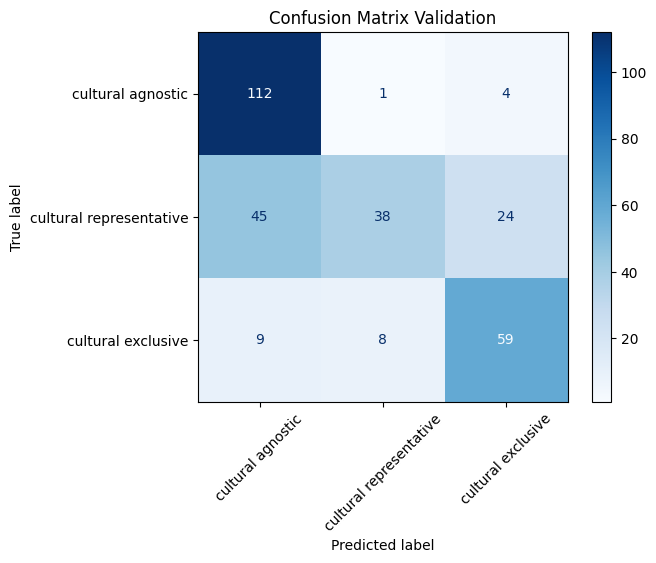

In [ ]:
Y_true_valid=numerical_label(X_valid[0:,6]) #transform in numerical label the validation set 

Y_pred=np.zeros(X_valid_emb.shape[0],dtype=np.int32)

for i in range(0,X_valid_emb.shape[0]):
    #predict every sample of validation with Centroid CA, Centroid CR, Centroid CE and corresponding property weights wrt CA,CR,CE
    index_class_valid=predict_entity_score(X_valid_emb[i],centroids["centroid_CA"],centroids["centroid_CR"],centroids["centroid_CE"],weights["weights_properties_CA"],weights["weights_properties_CR"],weights["weights_properties_CE"])
    #storing all class predicted 
    Y_pred[i]=index_class_valid


labels=["cultural agnostic","cultural representative","cultural exclusive"]
#classification report 
report=classification_report(Y_pred,Y_true_valid, target_names=labels)
print("classification report:\n",report)

#storing classification report on file "classification_report_validation.txt"
with open("classification_report_validation.txt", "w") as f:
    f.write(report)

#plot Confusion matrix 
cm_validation=confusion_matrix(Y_true_valid,Y_pred,labels=[0,1,2])
disp_conf_matrix=ConfusionMatrixDisplay(confusion_matrix=cm_validation,display_labels=labels)
disp_conf_matrix.plot(cmap=plt.cm.Blues,xticks_rotation=45)
plt.title("Confusion Matrix Validation")
#plt.tight_layout()
plt.show()
plt.savefig("confusion_matrix_validation.png")
plt.close()



In [ ]:
start_time = time.time()
print("Embedding culture representative samples (GPU)")
culture_representative_train_gpu = embedding_sample_optimized_gpu(
    X_train_numpy[X_train_numpy[:, 6] == 'cultural representative'],
    vocabulary_torch, client, extract_entity_id, device
)
print(f"--Embedding culture representative sample time: {time.time() - start_time:.4f} seconds")

start_time = time.time()
print("--Embedding culture agnostic sample (GPU)")
culture_agnostic_train_gpu = embedding_sample_optimized_gpu(
    X_train_numpy[X_train_numpy[:, 6] == 'cultural agnostic'],
    vocabulary_torch, client, extract_entity_id, device
)
print(f"--Embedding culture agnostic sample time: {time.time() - start_time:.4f} seconds")

start_time = time.time()
print("--Embedding Culture exclusive sample (GPU)")
culture_exclusive_train_gpu = embedding_sample_optimized_gpu(
    X_train_numpy[X_train_numpy[:, 6] == 'cultural exclusive'],
    vocabulary_torch, client, extract_entity_id, device
)
print(f"--Embedding Culture exclusive sample time: {time.time() - start_time:.4f} seconds")

print(f"culture_agnostic_train_gpu: {culture_agnostic_train_gpu.cpu().numpy()}")
print(f"cutlure agnostic shape {culture_agnostic_train_gpu.shape}")
print(f"culture_representative_train_gpu {culture_representative_train_gpu.cpu().numpy()}")
print(f"culture_representative_train_gpu shape {culture_representative_train_gpu.shape}")
print(f"culture_exclusive_train_gpu {culture_exclusive_train_gpu.cpu().numpy()}")
print(f"culture_exclusive_train_gpu shape {culture_exclusive_train_gpu.shape}")

# Calcolo dei centroidi sulla GPU
centroid_agnostic_gpu = culture_agnostic_train_gpu.float().mean(dim=0)
print(f"centroid agnostic for each property (GPU) {centroid_agnostic_gpu.shape}", centroid_agnostic_gpu.cpu().numpy())
centroid_representative_gpu = culture_representative_train_gpu.float().mean(dim=0)
print(f"centroid_representative (GPU) {centroid_representative_gpu.shape}", centroid_representative_gpu.cpu().numpy())
centroid_exclusive_gpu = culture_exclusive_train_gpu.float().mean(dim=0)
print(f"centroid_exclusive (GPU) {centroid_exclusive_gpu.shape}", centroid_exclusive_gpu.cpu().numpy())

# Calcolo di sigma basato sui dati embeddati (ora su GPU)
all_data_gpu = t.cat([
    culture_agnostic_train_gpu.float(),
    culture_representative_train_gpu.float(),
    culture_exclusive_train_gpu.float()
], dim=0)
distances_gpu = t.cdist(all_data_gpu, all_data_gpu)
sigma_gpu = 1 / (t.sqrt(t.tensor(2.0, device=device)) * (distances_gpu.mean() + 1e-8))

# Calcolo dei pesi con il kernel gaussiano (ora sugli embedding sulla GPU)
embeddings_agnostic_gpu = culture_agnostic_train_gpu.float()
weights_agnostic_gpu = gaussian_kernel_estimation_torch(embeddings_agnostic_gpu, centroid_agnostic_gpu.unsqueeze(0), sigma_gpu).mean(dim=0)

embeddings_representative_gpu = culture_representative_train_gpu.float()
weights_representative_gpu = gaussian_kernel_estimation_torch(embeddings_representative_gpu, centroid_representative_gpu.unsqueeze(0), sigma_gpu).mean(dim=0)

embeddings_exclusive_gpu = culture_exclusive_train_gpu.float()
weights_exclusive_gpu = gaussian_kernel_estimation_torch(embeddings_exclusive_gpu, centroid_exclusive_gpu.unsqueeze(0), sigma_gpu).mean(dim=0)

# Normalizzazione dei pesi (ora su GPU)
weights_agnostic_gpu /= (weights_agnostic_gpu.sum() + 1e-8)
print("weights agnostic normalized for every property (GPU)")
weights_representative_gpu /= (weights_representative_gpu.sum() + 1e-8)
weights_exclusive_gpu /= (weights_exclusive_gpu.sum() + 1e-8)

# Funzione di predizione ottimizzata per la GPU (gestisce input NumPy e lo sposta sulla GPU)
def predict_entity_score_optimized_gpu(x_sample_np, centroid_CA_gpu, centroid_CR_gpu, centroid_CE_gpu,
                                      weights_agnostic_gpu, weights_representative_gpu, weights_exclusive_gpu,
                                      sigma_gpu):
    """Predice il punteggio di appartenenza usando tensori PyTorch sulla GPU."""
    x_sample = t.tensor(x_sample_np, dtype=t.float32, device=centroid_CA_gpu.device)

    similarity_sample_CA = gaussian_kernel_estimation_torch(x_sample.unsqueeze(0), centroid_CA_gpu.unsqueeze(0), sigma_gpu)
    similarity_sample_CR = gaussian_kernel_estimation_torch(x_sample.unsqueeze(0), centroid_CR_gpu.unsqueeze(0), sigma_gpu)
    similarity_sample_CE = gaussian_kernel_estimation_torch(x_sample.unsqueeze(0), centroid_CE_gpu.unsqueeze(0), sigma_gpu)

    weighted_sample_agnostic = x_sample * weights_agnostic_gpu
    weighted_sample_representative = x_sample * weights_representative_gpu
    weighted_sample_exclusive = x_sample * weights_exclusive_gpu

    total_score_agnostic = weighted_sample_agnostic.sum() * similarity_sample_CA
    total_score_representative = weighted_sample_representative.sum() * similarity_sample_CR
    total_score_exclusive = weighted_sample_exclusive.sum() * similarity_sample_CE

    return t.argmax(t.stack([total_score_agnostic, total_score_representative, total_score_exclusive])).item()

# Esempio di predizione
if X_train.shape[1] > len(vocabulary):
    sample_to_predict = np.random.rand(len(vocabulary)) # Crea un campione casuale di embedding
else:
    sample_to_predict = np.random.rand(len(vocabulary)) # Genera un campione casuale se X_train non ha abbastanza colonne

prediction = predict_entity_score_optimized_gpu(
    sample_to_predict,
    centroid_agnostic_gpu,
    centroid_representative_gpu,
    centroid_exclusive_gpu,
    weights_agnostic_gpu,
    weights_representative_gpu,
    weights_exclusive_gpu,
    sigma_gpu
)
print(f"Prediction for sample: {prediction}")